<a href="https://colab.research.google.com/github/Jin-jin-jara/Dacon-Competition-NLP/blob/master/DACON_%EA%B8%88%EC%9C%B5%EB%AC%B8%EC%9E%90_%EB%B6%84%EC%84%9D%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 금융문자 분석경진대회

**Overview**

올해 1월부터 7월까지 스미싱 범죄 건수는 17만6220건으로 지난해 같은 기간(14만5093건)에 비해 21.5% 증가했습니다.

특히 최근 교묘하고 지능적인 스미싱 문자 패턴으로 인해 고객들의 피해가 증가하고 있습니다. 이를 방지하기 위해 kb 금융그룹과 KISA는 데이코너들에게 도움을 요청합니다.

주최/주관
- 주최 : KB금융지주, DACON , KISA(한국인터넷진흥원)
- 주관 : DACON

**Problem Statement**

데이콘 금융문자 분석 경진대회에서 풀어야하는 문제는 약 26만건의 문자 데이터를 분석하여 고객들이 받은 문자가 스미싱(금융사기)문자인지 은행에서 온 정상적인 문자인지를 구별하는 것입니다. 한 가지 흥미로웠던 점은 데이콘측에서 요구한건 문자가 스미싱 문자인지 정상 문자인지 구분하는 단순한 분류(classification) 문제가 아니라 하나하나의 문자가 스미싱 문자인지 아닌지 예측값의 확률을 구해 제출할 것을 요구했다는 점입니다. 

**Brief introduction to the data**

id - 각 문자가 가지고 있는 고유 구분 번호입니다.(train Data와 public_test Data의 id는 중복되지 않습니다.)

year_month - 고객이 문자를 전송 받은 년도와 월을 나타냅니다.

text - 고객이 전송 받은 문자의 내용입니다. 이번 프로젝트의 핵심적인 데이터입니다. text 컬럼의 데이터는 개인정보 보호를 위해, 개인정보로 간주될 수 있는 이름, 전화번호, 은행 이름, 지점명은 X 혹은 *로 필터링 되어있습니다. 

smishing - 해당 문자의 스미싱 여부입니다. (0 - 스미싱 아님(정상 문자), 1 -  스미싱)



## 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 탐색적 데이터 분석EDA(Exploratory Data Analysis)

### 필요 패키지 다운로드

keras - 케라스는 파이썬으로 구현된 쉽고 간결한 딥러닝 라이브러리입니다. 직관적인 API를 제공하고 있기 때문에 비전문가도 쉽게 딥러닝 모델을 개발하고 활용할 수 있습니다. 

pandas와 numpy - 데이터 전처리 작업과 분석을 위한 라이브러리입니다.

sklearn - 하이퍼파라미터 튜닝과 CV(Cross Validation)용도로 사용했습니다.

gensim - 단어 임베딩 방법으로 Word2Vec모델을 사용하기 위한 라이브러리입니다.

matplotlib과 seaborn - 파이썬의 시각화 라이브러리입니다.

In [2]:
# 데이터 전처리
import numpy as np      
import pandas as pd       
from tqdm import tqdm, tqdm_notebook
import random   
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences  
import re

# 데이터 샘플링
from imblearn.under_sampling import RandomUnderSampler 

# lstm_model 관련
from keras.layers import *      
from keras import backend as K    
from keras import optimizers    
import keras    
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, BatchNormalization, Dropout 
from keras.models import Sequential   
from keras import Input, Model 

# 시각화 라이브러리
import matplotlib.pyplot as plt   
import seaborn as sns

# Word2Vec 모델 관련
from gensim.models import Word2Vec, Phrases   
from gensim.models import KeyedVectors  

# 하이퍼파라미터와 CV(Cross Validation) 관련
from sklearn.model_selection import GridSearchCV, StratifiedKFold   
from sklearn.model_selection import cross_val_score


from keras.callbacks import *
from keras.utils.np_utils import to_categorical



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### 데이터 불러오기

train의 행은 약 29만개, test의 행은 약 1600개로 되어있습니다. 데이터셋의 구성은 굉장히 간결합니다.

In [3]:
train = pd.read_csv("/content/drive/My Drive/14th/train.csv") # train.csv 불러오기
test = pd.read_csv("/content/drive/My Drive/14th/public_test.csv") # test.csv 불러오기

print(test.shape)
print(train.shape)

(1626, 3)
(295945, 4)


In [4]:
train.head()

,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0


In [5]:
test.head()

,id,year_month,text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...


분석해야 하는 데이터에 nan값이 있으면 적절한 처리를 해줘야하지만, 확인 결과 데이터 셋에 비어있는 값은 없어보입니다.

In [6]:
np.sum(train['text'].isna()), np.sum(train['year_month'].isna())

(0, 0)

train 데이터셋에서 정상 문자의 개수는 약 28만개, 스미싱 문자의 개수는 2만개가 안됩니다. 정상 문자와 스미싱 문자의 비율은 94:6으로 클래스 불균형 문제가 발생합니다. 집중해야하는 값은 스미싱 문자인데 스미싱 문자의 비율이 너무 적기 때문에 적절히 처리해줘야할 필요가 있습니다.그래프로 보면 그 차이가 눈에 쉽게 들어옵니다.(수정하기)

In [7]:
print("정상 문자의 개수 : {}".format(len(train.loc[train['smishing']==0])))
print("스미싱 문자의 개수 : {}".format(len(train.loc[train['smishing']==1])))

정상 문자의 개수 : 277242
스미싱 문자의 개수 : 18703


In [8]:
smishing = train.loc[train['smishing']==1]
non_smishing = train.loc[train['smishing']==0]
num_data = len(train['smishing'])

print("정상 문자 비율 : {}%".format(round(len(non_smishing) / num_data * 100, 3)))
print("스미싱 문자 비율 : {}%".format(round(len(smishing) / num_data * 100, 3)))

정상 문자 비율 : 93.68%
스미싱 문자 비율 : 6.32%


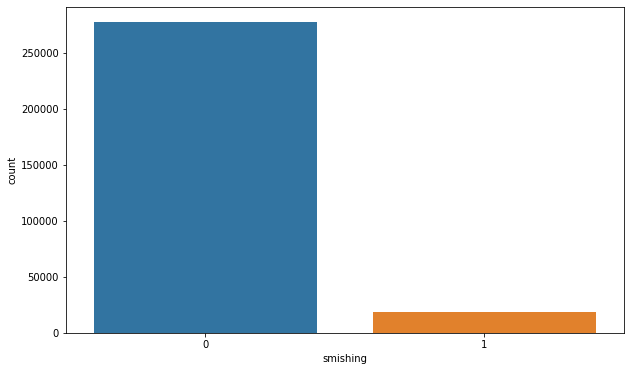

In [9]:
plt.figure(figsize=(10,6))

sns.countplot(data=train, x="smishing")

년월 데이터를 들여다보면 2017년 4월에서 6월까지 특히 문자 발송이 많긴 하지만 스미싱 문자의 발송량에는 큰 변화가 없습니다. 스미싱 문자는 2017년부터 2018년 12월 까지 점진적으로 증가하는 추세를 보입니다. 년월 데이터는 스미싱 문자와 정상 문자를 분류하는데 크게 도움되는 특징은 아닌 것 같습니다.

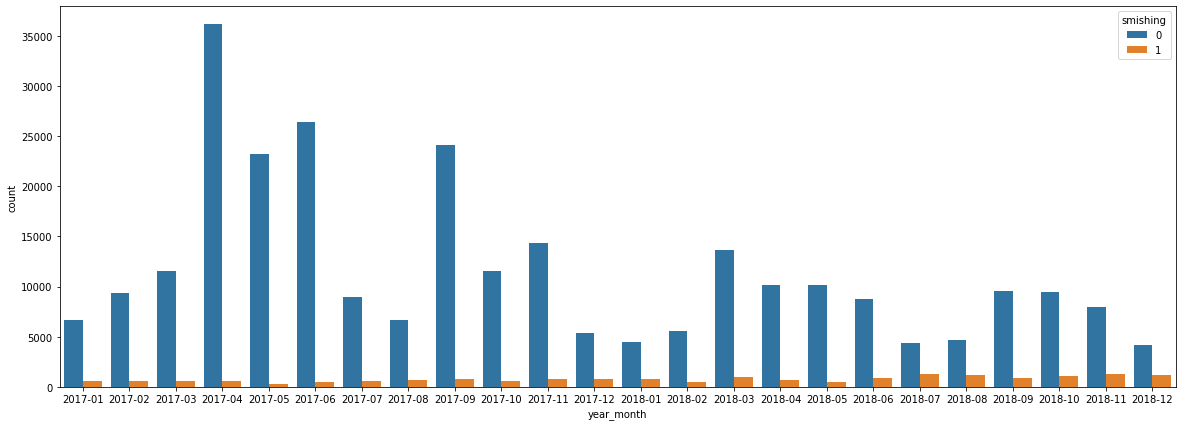

In [10]:
plt.figure(figsize=(20,7))

sns.countplot(data=train, x='year_month', hue='smishing')

이제 문자의 길이를 살펴보겠습니다. 

In [11]:
train['length'] = train['text'].apply(lambda x: len(x))
smishing = train.loc[train['smishing']==1]
non_smishing = train.loc[train['smishing']==0]

train.head()

,id,year_month,text,smishing,length
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0,24
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0,37
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0,81
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0,174
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0,40


대부분 문자의 길이는 0~200자 사이에 분포합니다.

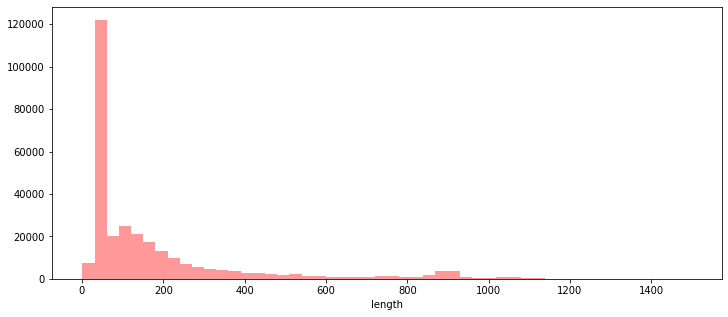

In [12]:
plt.figure(figsize=(12,5))

sns.distplot(train['length'], kde=False,  bins = 50, color='r')

조금 더 자세히 살펴보겠습니다. 정상 문자는 대부분 길이가 그렇게 길지 않은 것을 볼 수 있습니다. 대부분의 정상 문자들은 길이가 0-200 사이에 있습니다. 반면 스미싱 문자는 길이가 굉장히 긴 문자가 많습니다. 스미싱 문자는 800-1100자 사이에 글자 길이가 집중 되어있습니다.

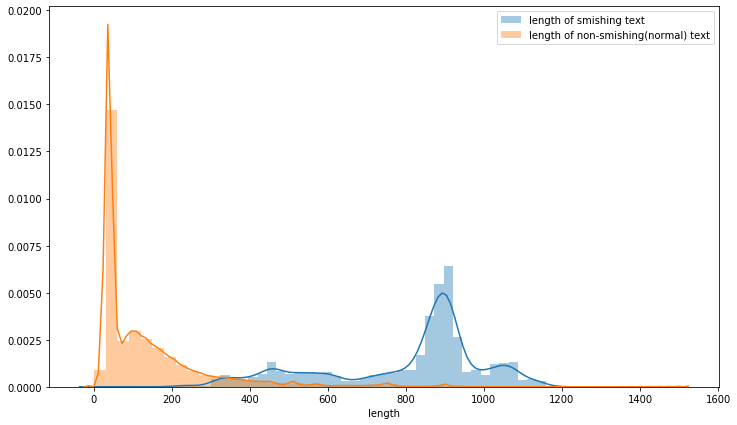

In [13]:
plt.figure(figsize=(12, 7))
sns.distplot(smishing['length'], label="length of smishing text")
sns.distplot(non_smishing['length'], label="length of non-smishing(normal) text")

plt.legend()

In [14]:
train['length'].describe()

count    295945.000000
mean        175.911703
std         223.469343
min           1.000000
25%          40.000000
50%          88.000000
75%         201.000000
max        1498.000000
Name: length, dtype: float64

In [15]:
print(np.percentile(train['length'], 80))
print("전체 문자의 평균 길이 : %d"%np.mean(train['length']))
print("스미싱 문자의 평균 길이 : %d"%np.mean(smishing['length']))
print("정상 문자의 평균 길이 : %d"%np.mean(non_smishing['length']))

245.0
전체 문자의 평균 길이 : 175
스미싱 문자의 평균 길이 : 801
정상 문자의 평균 길이 : 133


전체 데이터 길이의 평균은 176자이고, 가장 긴 데이터는 1498개의 문자를 보유하고 있고, 가장 짧은 데이터는 1개의 문자를 보유하고 있습니다. 80%의 데이터들은 길이가 245보다 작습니다. 하지만 이는 정상 문자가 스미싱 문자보다 약 15배 많기 때문에 평균이 정상 문자쪽으로 쏠려 나타나기 때문입니다. 스미싱 문자와 정상 문자를 분리해서 보면, 스미싱 문자의 평균 길이는 801자, 정상 문자의 평균 길이는 133자로 큰 차이를 보입니다.

In [16]:
iqr1 = train['length'].describe()['25%']
iqr3 = train['length'].describe()['75%']

ceil_outlier = iqr3 + 1.5 * (iqr3 - iqr1)
bot_outlier = iqr1 - 1.5 * (iqr3 - iqr1)

outlier = (np.percentile(train['length'], 5), np.percentile(train['length'], 95))

(ceil_outlier, bot_outlier), outlier

((442.5, -201.5), (32.0, 791.0))



너무 긴 문자나 너무 짧은 문자는 이상치outlier로 분류해 제거해야합니다. 두 방법으로 이상치outlier를 계산해 봤습니다. 첫 번째 방식으로 나온 위쪽 아웃라이어는 442.5, 아래쪽은 음수가 되었습니다. 두 번째 방식은 5%에서 95% 범위 밖에 있는 데이터들은 아웃라이어로 처리합니다. 하지만 우리가 집중해야하는 스미싱 문자들의 길이의 평균은 801인데 이러한 방식으로 아웃라이어를 제거해버리면 스미싱 문자 대부분이 제거될 것입니다. 그렇기 때문에 길이가 긴 문자들은 그대로 두고,  너무 짧은 문자만 아래 워드 임베딩 과정에서 제거하도록 하겠습니다.

# 데이터 전처리

### train 데이터 클래스 불균형 문제

### undersampling

위에서 살펴보았다시피 정상 문자의 개수와 스미싱 문자의 개수는 94:6 비율로 차이가 납니다. 소수의 클래스에 특별히 더 관심이 있는 경우에 불균형한 클래스의 균형을 맞추기 위해 under sampling으로 정상 문자와 스미싱 문자의 비율을 조절할 수도 있지만 under sampling을 수행하면 정보가 너무 많이 소실되어 그다지 좋은 생각은 아닌 것 같습니다. over_sampling을 해 소수 클래스의 데이터를 늘릴 수도 있습니다. 하지만 over sampling의 단점은 기존 데이터를 기반으로 비슷한 데이터를 새로 생성하기 때문에 의도치 않은 노이즈 데이터가 생성될 수 있습니다. 또한 새로운 데이터 예측에는 취약합니다. under sampling과 over sampling 각각이 장단점을 지니고 있는데, 이번 프로젝트에서는 따로 under sampling이나 over sampling하지 않고 전체 데이터를 그대로 사용했습니다.

In [17]:
def undersampling(minor, major, train=train, random_state=47):
  X = train.drop('smishing', axis= 1)
  y= train['smishing']
  rus=RandomUnderSampler(random_state=random_state, sampling_strategy=minor/major)
  x_sampled, y_sampled = rus.fit_resample(X, y)
  col = train.columns
  train_sample = pd.DataFrame(np.hstack((x_sampled, y_sampled.reshape(-1,1))), columns=col)

  return train_sample

train_sample = undersampling(2,8)
print(train_sample.shape)

(93515, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## 데이터 전처리

텍스트 데이터가 전처리가 되지 않은 상태이기 때문에, 좋은 예측값을 위해 적절한 전처리 작업이 필요합니다. 텍스트 데이터를 위한 전처리 작업에는 정규화, 정제, 불용어 제거등이 있습니다.

### 불용어 제거 및 토크나이징

#### mecab install

khaii, okt, mecab등의 형태소 분석기를 사용했습니다. okt는 한국어 어간 추출과 정규화를 지원했지만 학습이 너무 느리고 띄어쓰기를 잘 구분하지 못했습니다. khaii는 준수한 성능을 보였지만 mecab만큼 빠르진 않았습니다. 성능과 속도 면에서 mecab이 가장 준수했으므로 이 프로젝트에서는 mecab을 사용했습니다.

In [17]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 50 (delta 18), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [18]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [19]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 162kB/s 
     |████████████████████████████████| 2.3MB 33.3MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-02-03 00:30:06--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.2, 18.205.93.1, 18.205.93.0, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?

In [0]:
from konlpy.tag import Mecab
mecab = Mecab()



mecab에 pos로 의미를 품고 있는 품사(NNG(일반명사), NNP(고유명사), VV(동사), VA(형용사), MAG(일반부사))만 사용하면서 많은 의미없는 단어들이 빠졌기 때문에 기본적인 불용어만 제거하였습니다.

In [0]:
combine = [train, test]
for dataset in combine:
  # train과 test의 구두점과 특수문자 제거
  dataset['text(clean)'] = dataset['text'].str.replace('[\\WX]', ' ')

# 문장에서 뜻이 될 만한 품사 태그
p = ["NNG", "NNP", "VV", "VA", "MAG"]
# 불용어
stopwords = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ',
             'ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ','가', '나', '다', '라',
             '마', '바', '사', '아', '자', '차', '카', '타', '파', '하', '가가', '듀']

In [0]:
# 문장 토큰화
def tokenizer(data, pos=p, stopword=stopwords):

  tokened = mecab.pos(data)

  return [word for word, tag in tokened if tag in pos and word not in stopword]

In [23]:
# undersampling한 train 데이터 문장 토큰화
train['tokenized'] = train['text(clean)'].apply(tokenizer)

print(train.shape)
train.head(2)

(295945, 7)


,id,year_month,text,smishing,length,text(clean),tokenized
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0,24,은행성산 팀장입니다 행복한주말되세요,"[은행, 성산, 팀장, 행복, 주말]"
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0,37,오늘도많이웃으시는하루시작하세요 은행 진월동VIP라운지 올림,"[오늘, 많이, 웃, 하루, 시작, 은행, 진월동, 라운지]"


In [24]:
# test 데이터 문장 토큰화
test['tokenized'] = test['text(clean)'].apply(tokenizer)

print(test.shape)
test.head(2)

(1626, 5)


,id,year_month,text,text(clean),tokenized
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...,고객님 안녕하세요 새롭게 시작하는 한 주 행복 가득하시길 기원합니다 지난...,"[고객, 안녕, 새롭, 시작, 행복, 가득, 기원, 지난주, 글로벌, 증시, 파월,..."
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...,긴급 안내 은행 가락동 지점 헬리오 기본 대출이자를 ...,"[긴급, 안내, 은행, 가락동, 지점, 헬리오, 기본, 대출, 이자, 조합, 납부,..."


이제 데이터의 전처리 과정을 거쳤으니, train셋을 모델에 훈련 시킬 train셋과 모델의 성능을 평가하기 위한 val(validation)셋으로 나눠줍니다.

In [25]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.3, random_state=47)
train.shape, val.shape

((207161, 7), (88784, 7))

# 워드 임베딩(Word Embedding)과 모델 생성

## 워드 임베딩 - Word2Vec

Technical University of Darmstadt의 Nils Reimers 박사의 "Optimal Hyperparameters for Deep LSTM-Networks for Sequence Labeling Tasks" 논문을 보면 모델의 성능에 영향을 미치는 것은 lstm 모델의 세세한 파라미터들보단 미리 학습된 워드 임베딩과 LSTM 모델의 가장 마지막 층이라고 말합니다. 

다단어 표현 추출(multi-word expressions) - 케라스에서 제공하는 Phrases 함수로 자주 함께 나오는 단어들은 3단어짜리 구문으로 묶어 줍니다. 사전에 있는 단어는 아니지만 실제로 자주 사용하는 단어들을 묶어 한 단어로 인식하게 합니다. ex) 여신_영업부, 인터넷_스타_뱅킹

In [26]:
bigrams = Phrases(sentences=train.tokenized)
trigrams = Phrases(sentences=bigrams[train.tokenized])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


전처리한 단어들을 사용해 Word2Vec 모델 생성. Word2Vec의 CBOW(Continuous Bag of Words)와 Skip-Gram중 CBOW는 빠르게 학습하지만 skip-gram방식이 자주 등장하지 않는 단어에 대해서 더 정확한 결과를 내기 때문에 skip-gram을 사용하였습니다. 

임베딩 사이즈는 임베딩 사이즈는 [2, 4, 8, 16, 32, 64, 128, 256, 512] 중 256 사이즈일 때 가장 좋은 성능이 나왔기 때문에 256으로 고정하여 사용하였습니다.

In [0]:
N_SPLITS = 5
EMBEDDING_SIZE = 256

In [28]:
tri_model = Word2Vec(sentences = trigrams[bigrams[train.tokenized]],
                     size=EMBEDDING_SIZE, 
                     window=10, 
                     # 10번 이하로 등장하는 단어들은 모델의 성능에 도움이 되지 않는다고 판단하여 학습하지 않습니다.
                     min_count=10, 
                     workers=4, 
                     # 0은 CBOW방식, 1은 Skip Gram방식입니다.
                     sg=1)
tri_model.wv.save_word2vec_format('w2v_model') 
loaded_model = KeyedVectors.load_word2vec_format("w2v_model")

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


워드투벡터 모델이 학습이 잘 되었는지 확인해보겠습니다. most_similar함수로 "날씨", "광고"과 가장 유사한 단어들을 확인해봤습니다. 

은행은 주기적으로 고객들에게 안부 문자를 보냅니다. 대부분의 안부 문자에는  "날씨"가 들어가는 것 같습니다. 워드투벡터 모델이 학습한 "날씨"와 가장 유사한 단어들을 보면 "갑자기_날씨", "감기_유행", "밤낮_일교차" 등이 있습니다. 날씨가 추워지니 건강 잘 챙기시라는 등의 안부 문자를 은행에서 종종 받는걸 생각하면 word2vec 모델이 유사도를 잘 구한 것 같습니다. 

In [29]:
tri_model.wv.most_similar("날씨")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('갑자기_날씨', 0.5816864967346191),
 ('밤낮_일교차', 0.5688504576683044),
 ('기온', 0.5680727958679199),
 ('쌀쌀', 0.5679805278778076),
 ('수분_섭취', 0.5654799938201904),
 ('감기_유행', 0.5649789571762085),
 ('습하', 0.5609647035598755),
 ('비_오', 0.5601809620857239),
 ('기온_변화', 0.5591260194778442),
 ('외출_마스크', 0.5585779547691345)]

"광고"라는 단어와 가장 유사한 단어들로는 "신상품_출시", "광고_신용협동조합", "최신_정보"등이 있습니다. 은행에서는 안부문자뿐 아니라 금융 상품에 대한 광고 문자도 고객들에게 발송하므로 이런 단어들은 상식적으로 생각하기에 충분히 유사한 단어들이라고 볼 수 있을 것 같습니다. word2vec 모델은 잘 학습된 것 같습니다. 또한 Phrases함수를 사용한 다단어 표현 추출도 잘된 것으로 보입니다.  

In [30]:
tri_model.wv.most_similar("광고")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('광고_신용협동조합', 0.463154673576355),
 ('신상품_출시', 0.45798012614250183),
 ('광고_은_행', 0.44043245911598206),
 ('안내문_아직_고금리', 0.4393822252750397),
 ('국공립_사립_학교_교직원', 0.4359458088874817),
 ('일전_소속', 0.43267208337783813),
 ('여신상', 0.4319918751716614),
 ('발신', 0.4302227199077606),
 ('지원_팀', 0.42501264810562134),
 ('많이_많이_가져가', 0.4241330623626709)]

Word2Vec모델에서 학습한 단어들의 수는 16,403개 입니다. 

In [31]:
max_words =len(tri_model.wv.vocab)
print("vocabulary size : ", max_words)

vocabulary size :  16403


word2vec 모델로 벡터화된 단어들을 문장에 넣고 문장 길이가 전부 다르기 때문에 padding으로 가장 긴 문장을 기준으로 문장 길이를 맞춰주었습니다.

In [32]:
def vectorizer_data(data, vocab: dict) -> list:
  print("Vectorize sentences... ", end='\r')
  keys= list(vocab.keys())
  filter_unknown = lambda word : vocab.get(word, None) is not None
  encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
  vectorized = list(map(encode, data))
  print("Vectorize sentece... (done)")
  return vectorized

X_data = train.tokenized
input_length = max(list(map(len, X_data)))
X = pad_sequences(
    sequences = vectorizer_data(X_data, vocab=tri_model.wv.vocab),
    maxlen= input_length,
    padding="post"
)
y = train['smishing'].values

Vectorize sentece... (done)


In [33]:
X_test = pad_sequences(
    sequences = vectorizer_data(test.tokenized, vocab=tri_model.wv.vocab),
    maxlen= input_length,
    padding="post"
)

Vectorize sentece... (done)


In [34]:
X_val = pad_sequences(
    sequences = vectorizer_data(val.tokenized, vocab=tri_model.wv.vocab),
    maxlen= input_length,
    padding="post"
)

y_val = val['smishing'].values

Vectorize sentece... (done)


In [35]:
X.shape, y.shape, X_val.shape, y_val.shape

((207161, 289), (207161,), (88784, 289), (88784,))

Attention 모델은 Kaggle Attention Baseline의 코드를 참고했습니다. https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-672-lb

## 어텐션(Attention)을 적용한 양방향 LSTM모델

 우리가 해결하려는 문제는 텍스트 시퀀스를 입력받아 스미싱 문자일 확률을 예측하는 문제입니다. 텍스트를 처리하는 문제는 머신러닝 알고리즘보다 딥러닝 알고리즘이 더 좋은 성능을 낸다고 판단하여 딥러닝 알고리즘을 사용했습니다. 밑바닥부터 공부하면서 시작했기 때문에 기본적인 RNN모델로 시작해서 RNN모델을 개선한 LSTM모델, 양방향 LSTM모델을 거쳐 마지막엔 Attention기법을 가미해 최종적인 모델을 만들었습니다.


미국 스탠포드대학의 Stanford NLP group을 이끄는 Chistopher Manning 교수의 말을 빌리면, 


"The de facto consensus in NLP in 2017 is that no matter what the task, you throw a BiLSTM at it, with attention if you need information flow, and you get great perfomance!"

어떤 자연어 처리 문제든 Attention을 사용한 양방향 LSTM 거의 항상 좋다고 합니다!

Attention 모델은 Kaggle Attention Baseline의 코드를 참고해 사용했습니다. https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043

In [0]:
class Attention(Layer):

  def __init__(self, step_dim,
                W_regularizer=None, b_regularizer=None,
                W_constraint=None, b_constraint=None,
                bias=True, **kwargs):
      """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
      self.supports_masking = True
      # 가중치 초기값으로 Xavier 초기값과 He 초기값중 He 초기값의 성능이 더 좋았기 때문에 기존 Xavier초기값에서 He 초기값으로 바꿔 사용했습니다.
      # self.init = keras.initializers.get('glorot_uniform')
      self.init = keras.initializers.he_normal(seed=47)
      self.W_regularizer = keras.regularizers.get(W_regularizer)
      self.b_regularizer = keras.regularizers.get(b_regularizer)

      self.W_constraint = keras.constraints.get(W_constraint)
      self.b_constraint = keras.constraints.get(b_constraint)

      self.bias = bias
      self.step_dim = step_dim
      self.features_dim = 0
      super(Attention, self).__init__(**kwargs)

  def build(self, input_shape):
      assert len(input_shape) == 3

      self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
      self.features_dim = input_shape[-1]

      if self.bias:
          self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
      else:
          self.b = None

      self.built = True

  def compute_mask(self, input, input_mask=None):
      return None

  def call(self, x, mask=None):
      features_dim = self.features_dim
      step_dim = self.step_dim

      eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

      if self.bias:
          eij += self.b

      eij = K.tanh(eij)

      a = K.exp(eij)

      if mask is not None:
          a *= K.cast(mask, K.floatx())

      a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

      a = K.expand_dims(a)
      weighted_input = x * a
      return K.sum(weighted_input, axis=1)

  def compute_output_shape(self, input_shape):
      return input_shape[0],  self.features_dim

NN(Neurel Network) LSTM(Long Short-Term Memory) 모델을 만듭니다.

In [37]:
def build_model(embedding_matrix:np.ndarray, input_length: int):
  model = keras.Sequential()
  # 2차원의 정수 인코딩된 텍스트 데이터를 lstm모델에 입력하기 위해(LSTM 모델은 3차원 텐서를 입력값으로 받습니다) 케라스는 랜덤 임베딩층을 지원합니다. 
  # 하지만 저희는 미리 학습시킨 Word2Vec 모델로 임베딩층을 대신했습니다.
  model.add(Embedding(
      input_dim = embedding_matrix.shape[0],
      output_dim = embedding_matrix.shape[1], 
      input_length = input_length,
      weights = [embedding_matrix],
      # 이미 학습 시켰기 때문에 trainable=False로 설정해줍니다.
      trainable=False
  ))
  # 양방향 LSTM 층입니다. 
  # 어텐션 모델을 사용하기 때문에 return_sequences값은 True로 바꿔 LSTM층에서 나온 출력값을 어텐션과 연결합니다. 
  model.add(Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
  # 어텐션은 새로운 예측을 할 때 이전 시점의 중요한 단어들에 집중합니다.  
  # 때문에, 기울기 소실과 같은 치명적인 RNN기반 모델의 단점을 보완합니다.
  model.add(Attention(input_length))
  # 모델의 과대적합overfitting을 방지하기 위해 완전연결층 중간중간 드롭아웃dropout규제를 추가했습니다.
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.4))

  # 문자가 스미싱일 확률과 정상 문자일 확률을 출력해야 하므로 마지막 활성화 함수에는 softmax함수를 사용했습니다.
  model.add(Dense(2, activation="softmax"))
  # 확률적 경사하강법SGD(Stochatic Gradient Decent)기법을 사용했을 때보다 학습 속도가 빨랐기 때문에 Adam 옵티마이저optimizer를 사용했습니다.
  adam = optimizers.Adam(lr=0.001, amsgrad = True)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  model.summary()
  return model

model_lstm = build_model(embedding_matrix=tri_model.wv.vectors, input_length=X.shape[1])
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        min_delta=0,
                                                        patience=5,
                                                        verbose=0, mode='auto')











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 289, 256)          4199168   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 289, 256)          394240    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               545       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0  

모델이 완성되었으므로 학습을 시켜야합니다. 모델의 성능을 평가하고, 오버피팅을 방지하기 위해 따로 떼어두었던 validation data를 사용해 교차검증을 진행합니다.


너무 큰 배치 사이즈를 주면 학습은 빠르지만 학습이 뭉게집니다. 반대로 너무 작은 배치 사이즈를 주면 학습 속도가 너무 느려집니다. 학습 속도와 뭉게짐의 적절한 배치 사이즈를 찾아 epoch를 늘려 학습을 강화합니다.

## 모델 학습

In [38]:
batch_size = 1024

trained = model_lstm.fit(X, y, epochs=30, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 207161 samples, validate on 88784 samples
Epoch 1/30
207161/207161 [==============================] - 287s 1ms/step - loss: 0.0310 - acc: 0.9888 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 2/30
207161/207161 [==============================] - 281s 1ms/step - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0045 - val_acc: 0.9992
Epoch 3/30
207161/207161 [==============================] - 279s 1ms/step - loss: 0.0036 - acc: 0.9992 - val_loss: 0.0022 - val_acc: 0.9995
Epoch 4/30
207161/207161 [==============================] - 277s 1ms/step - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0018 - val_acc: 0.9996
Epoch 5/30
207161/207161 [==============================] - 274s 1ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0016 - val_acc: 0.9996
Epoch 6/30
207161/207161 [==============================] - 276s 1ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0015 - val_acc: 0.9996
Epoch 7/30
20

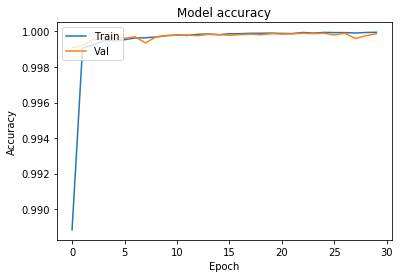

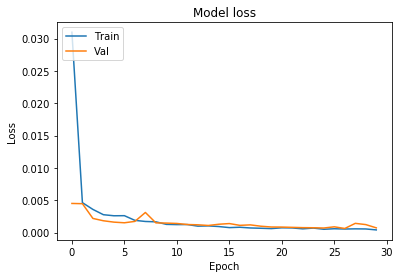

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(trained.history['acc'])
plt.plot(trained.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## 모델 평가

validation세트를 예측했을 때 99.9%이상의 높은 정확도를 보였습니다. 학습된 모델로 test셋을 예측하여 각 문자가 스미싱 문자일 '확률'을 출력해 제출해 최종적으로 0.9747400284, 97.47%의 정확도를 얻었습니다.

In [43]:
model_lstm.evaluate(X_val, y_val, batch_size=batch_size, workers=4)

88784/88784 [==============================] - 42s 468us/step


[0.0007322760151154178, 0.9998761038024869]

In [46]:
prediction = model_lstm.predict(X_test)
proba = model_lstm.predict_proba(X_test)

smishing_proba=list(map(lambda x: x[1],proba))
prediction[:10]

array([[9.9999964e-01, 3.8652072e-07],
       [9.9999988e-01, 1.0862106e-07],
       [1.0000000e+00, 7.1893864e-09],
       [1.0000000e+00, 6.0419123e-09],
       [1.0000000e+00, 1.8466594e-08],
       [1.0000000e+00, 9.0447099e-09],
       [1.0000000e+00, 1.6322499e-08],
       [9.9999988e-01, 1.3937061e-07],
       [1.0000000e+00, 1.4293659e-08],
       [1.0000000e+00, 5.5291420e-09]], dtype=float32)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/submission.csv', index_col= 'id')
submission['smishing'] = smishing_proba
submission.to_csv("/content/drive/My Drive/submission.csv")